# Titanic - Machine Learning from Disaster at kaggle

Добавьте необходимые пакеты для работы

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

Скачать данные для работы

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

Просмотр входных данных

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Данные имеют столбцы:
<br>- Survival: выжил ли пассажир или нет (0 или 1)
<br>- Pclass: Социально-экономический класс
<br>  + Upper: 1
<br>  + Middle: 2
<br>  + Lower: 3
<br>- Sex: пол пассажира (мужской или женский)
<br>- Age: возраст в годах (возраст является дробным, если он меньше 1. Если возраст оценивается, он         указывается в виде xx,5)
<br>- SibSp: Количество братьев и сестер/супругов на борту Титаника
<br>- Parch: Количество родителей/детей на борту Титаника
<br>- Ticker: номер билета
<br>- Fare: Пассажирский тариф
<br>- Cabin: Номер каюты
<br>- Embarked: порт посадки
<br>*Некоторые строки в столбце данных отсутствуют

 ## Наблюдайте за факторами, которые, как считается, влияют на выживание пассажиров

Общее количество пассажиров:

In [4]:
len(train)

891

Соотношение выживаемости: 0 = нет выживания, 1 = выживание

<AxesSubplot:ylabel='Survived'>

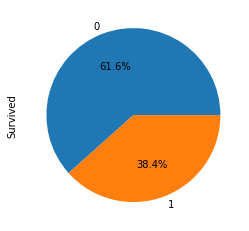

In [5]:
train["Survived"].value_counts().plot.pie(autopct="%1.1f%%")

Связь секса и выживания:

<AxesSubplot:ylabel='Sex'>

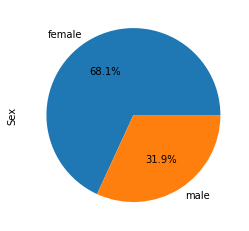

In [6]:
df_male = train[(train["Survived"] == 1) & (train["Sex"] == "male")]
df_female = train[(train["Survived"] == 1) & (train["Sex"] == "female")]
df_sur = pd.concat([df_male, df_female])
df_sur["Sex"].value_counts().plot.pie(autopct="%1.1f%%")

Женщины выживают больше, чем мужчины после несчастных случаев.
<br>
<br>Связь социального класса и выживания:

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

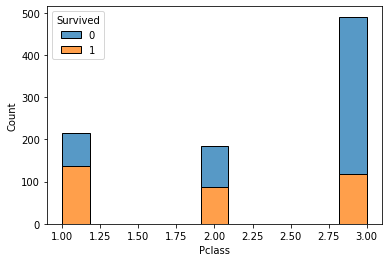

In [7]:
sns.histplot(data=train, x="Pclass", hue="Survived", multiple="stack")

Люди из высшего класса имеют более высокую выживаемость.
<br>
<br>Связь возраста и выживания:

<AxesSubplot:xlabel='Age', ylabel='Count'>

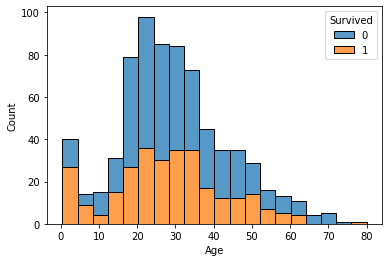

In [8]:
sns.histplot(data=train, x="Age", hue="Survived", multiple="stack")

Выживших детей было больше, чем пожилых людей, причем большинство составляли взрослые и люди среднего возраста.
<br>
<br>Используйте матрицу корреляции, чтобы просмотреть все факторы:

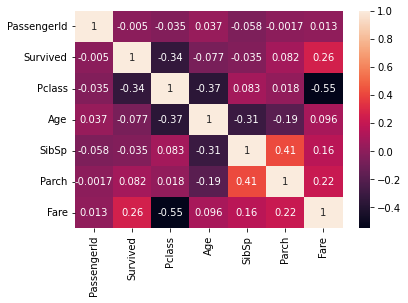

In [9]:
corr = train.corr()
dataplot = sns.heatmap(data=corr, annot=True)

Из матрицы видно, что фактор <Fare> положительно коррелирует с вероятностью выживания, а это означает, что человек, купивший билет с более высокой ценой, имеет больше шансов выжить.
<br>

 ## Использование контролируемого алгоритма машинного обучения RandomForest для прогнозирования классификации

Вход алгоритма может быть только в виде чисел. А входные данные помимо количественных данных, есть еще и категориальные данные, поэтому необходимо обрабатывать данные.

In [10]:
#создать два массива для выбора числовых и категориальных атрибутов
num_attrs = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
cat_attrs = ["Sex"]

In [11]:
attribs = ["Sex"]

def convert_cat(df, attrs):
    for col in attrs:
        df[col] = df[col].astype('category')
        
convert_cat(train, attribs)
convert_cat(test, attribs)

In [12]:
#преобразователь для выборки только полезных атрибутов
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrs):
        self.attrs = attrs
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attrs].values

In [13]:
#numerical pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attrs)),
    #NaN
    ("imputer", SimpleImputer(strategy="median"))
])

In [14]:
#categorical pipeline
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attrs)),
    #NaN
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("label_binarize", OneHotEncoder(sparse=False))
])

In [15]:
#объедините эти два конвейера, используя FeatureUnion, и поместите их в фрейм данных обучения
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion([
    ("num", num_pipeline),
    ("cat", cat_pipeline)
])

train_prepared = full_pipeline.fit_transform(train)
train_prepared_df = pd.DataFrame(train_prepared, columns=[
    "Pclass", "Age", "SibSp", "Parch", "Fare", "Female", "Male"])
test_prepared = full_pipeline.fit_transform(test)
test_prepared_df = pd.DataFrame(test_prepared, columns=[
    "Pclass", "Age", "SibSp", "Parch", "Fare", "Female", "Male"])

In [16]:
labels = train["Survived"]

model = RandomForestClassifier(n_estimators=100, max_depth=5, max_features='sqrt')
model.fit(train_prepared_df, labels)
predictions = model.predict(test_prepared_df)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('./submission.csv', index=False)

In [17]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
